## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [ ]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

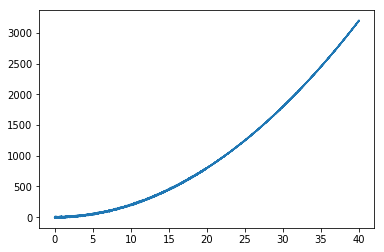

In [2]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 4, x.size)
x2 = np.linspace(20, 40, 10000)
deltax2 = np.random.normal(0, 1, x2.size)
z = np.linspace(0, 20, 10000)
deltaz = np.random.normal(0, 2, z.size)
z2 = np.linspace(20, 40, 10000)
deltaz2 = np.random.normal(0, 2, z.size)
y = 2 * x * z + deltax + deltaz
y2 = 2 * x2 * z2 + deltax2 + deltaz2
x_final = np.append(x, x2)
z_final = np.append(z, z2)
y_final = np.append(y, y2)
plt.plot(x_final,y_final)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output. Note that differently from the 1 input version, in this case the sigma is not squared. This is because the sigma here applied is the combination of the sigmas of the 2 inputs, each of them squared in the model

In [3]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (sigma+ epsilon)) + K.log(sigma + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

First we try a model without calculating the sigma and plot some results.

Epoch 1/200
20000/20000 [==============================] - 0s - loss: 2637143.2779 - mean_squared_error: 2637143.2779     
Epoch 2/200
20000/20000 [==============================] - 0s - loss: 2359980.9287 - mean_squared_error: 2359980.9287     
Epoch 3/200
20000/20000 [==============================] - 0s - loss: 2148895.3095 - mean_squared_error: 2148895.3095     
Epoch 4/200
20000/20000 [==============================] - 0s - loss: 1957869.1270 - mean_squared_error: 1957869.1270     
Epoch 5/200
20000/20000 [==============================] - 0s - loss: 1781926.4681 - mean_squared_error: 1781926.4681     
Epoch 6/200
20000/20000 [==============================] - 0s - loss: 1618938.8867 - mean_squared_error: 1618938.8867     
Epoch 7/200
20000/20000 [==============================] - 0s - loss: 1467625.7864 - mean_squared_error: 1467625.7864     
Epoch 8/200
20000/20000 [==============================] - 0s - loss: 1327076.8611 - mean_squared_error: 1327076.8611   
Epoch 9/200
20000/

20000/20000 [==============================] - 0s - loss: 16.4433 - mean_squared_error: 16.4433     
Epoch 71/200
20000/20000 [==============================] - 0s - loss: 16.4212 - mean_squared_error: 16.4212     
Epoch 72/200
20000/20000 [==============================] - 0s - loss: 16.3948 - mean_squared_error: 16.3948     
Epoch 73/200
20000/20000 [==============================] - 0s - loss: 16.3630 - mean_squared_error: 16.3630     
Epoch 74/200
20000/20000 [==============================] - 0s - loss: 16.3252 - mean_squared_error: 16.3252     
Epoch 75/200
20000/20000 [==============================] - 0s - loss: 16.2803 - mean_squared_error: 16.2803     
Epoch 76/200
20000/20000 [==============================] - ETA: 0s - loss: 17.5594 - mean_squared_error: 17.55 - 0s - loss: 16.2282 - mean_squared_error: 16.2282     
Epoch 77/200
20000/20000 [==============================] - 0s - loss: 16.1679 - mean_squared_error: 16.1679     
Epoch 78/200
20000/20000 [=====================

20000/20000 [==============================] - 0s - loss: 12.7045 - mean_squared_error: 12.7045     
Epoch 142/200
20000/20000 [==============================] - 0s - loss: 12.6958 - mean_squared_error: 12.6958     
Epoch 143/200
20000/20000 [==============================] - 0s - loss: 12.6876 - mean_squared_error: 12.6876     
Epoch 144/200
20000/20000 [==============================] - 0s - loss: 12.6802 - mean_squared_error: 12.6802     
Epoch 145/200
20000/20000 [==============================] - 0s - loss: 12.6740 - mean_squared_error: 12.6740     
Epoch 146/200
20000/20000 [==============================] - 0s - loss: 12.6688 - mean_squared_error: 12.6688     
Epoch 147/200
20000/20000 [==============================] - 0s - loss: 12.6647 - mean_squared_error: 12.6647     
Epoch 148/200
20000/20000 [==============================] - 0s - loss: 12.6615 - mean_squared_error: 12.6615     
Epoch 149/200
20000/20000 [==============================] - 0s - loss: 12.6589 - mean_squared

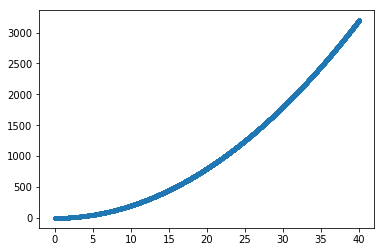

In [5]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds")(product)

rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit([x_final, z_final], y_final, batch_size=128, epochs=200, shuffle=False)
raw_result = rawmodel.predict([x_final, z_final])
plt.plot(x_final, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigmas are computed. In this case we have two sigmas, on for each input, that share the same network. Sigmas are squared and combined, by adding them, as a resulting sigma that is train in the loss together with the mean squared error of the labels and the predictions.

In [11]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
sigma_hidden1 = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_hidden2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
sigma_output = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds")(product)
sigma1_hidden1 = sigma_hidden1(input1)
sigma1_hidden2 = sigma_hidden2(sigma1_hidden1)
sigma1 = sigma_output(sigma1_hidden2)
sigma1_squared = multiply([sigma1,sigma1])
sigma2_hidden1 = sigma_hidden1(input2)
sigma2_hidden2 = sigma_hidden2(sigma2_hidden1)
sigma2 = sigma_output(sigma2_hidden2)
sigma2_squared = multiply([sigma2,sigma2])
sigma = add([sigma1_squared, sigma2_squared])
aleatoric_output = concatenate([preds, sigma])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.001)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.0001)
model = Model(inputs=[input1,input2],outputs=aleatoric_output)
model.compile(optimizer=nadam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_8 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
sigma (Dense)                    (None, 10)            20          input_7[0][0]                    
                                                                   input_8[0][0]                    
____________________________________________________________________________________________________
sigma2 (Dense)                   (None, 5)             55          sigma[0][0]             

In [12]:
model.fit([x_final, z_final], np.expand_dims(y_final, axis=1).repeat(2, axis=1), batch_size=64, epochs=2000, shuffle=False)

Epoch 1/2000
20000/20000 [==============================] - 0s - loss: 134472141.5584 - aleatoric_rms: 2342020.2063 - aleatoric_uncertainty: -12.2503     
Epoch 2/2000
20000/20000 [==============================] - 0s - loss: 35055500.4139 - aleatoric_rms: 2313114.8979 - aleatoric_uncertainty: -7.6221     
Epoch 3/2000
20000/20000 [==============================] - 0s - loss: 20634524.6718 - aleatoric_rms: 2294274.5006 - aleatoric_uncertainty: -6.5718     
Epoch 4/2000
20000/20000 [==============================] - 0s - loss: 14061000.9318 - aleatoric_rms: 2278853.0545 - aleatoric_uncertainty: -5.8355     
Epoch 5/2000
20000/20000 [==============================] - 0s - loss: 10332913.6341 - aleatoric_rms: 2265331.1052 - aleatoric_uncertainty: -5.2527    
Epoch 6/2000
20000/20000 [==============================] - 0s - loss: 7954295.9148 - aleatoric_rms: 2253005.3447 - aleatoric_uncertainty: -4.7619     
Epoch 7/2000
20000/20000 [==============================] - 0s - loss: 6318245.691

20000/20000 [==============================] - 0s - loss: 13953.0340 - aleatoric_rms: 1579538.6234 - aleatoric_uncertainty: 6.8370     
Epoch 55/2000
20000/20000 [==============================] - 0s - loss: 12428.6593 - aleatoric_rms: 1560002.5313 - aleatoric_uncertainty: 7.0415     
Epoch 56/2000
20000/20000 [==============================] - 0s - loss: 11072.8114 - aleatoric_rms: 1540349.1782 - aleatoric_uncertainty: 7.2453     
Epoch 57/2000
20000/20000 [==============================] - 0s - loss: 9866.6585 - aleatoric_rms: 1520590.8580 - aleatoric_uncertainty: 7.4484     
Epoch 58/2000
20000/20000 [==============================] - 0s - loss: 8793.4569 - aleatoric_rms: 1500740.4224 - aleatoric_uncertainty: 7.6507     
Epoch 59/2000
20000/20000 [==============================] - 0s - loss: 7838.3834 - aleatoric_rms: 1480809.1779 - aleatoric_uncertainty: 7.8524     
Epoch 60/2000
20000/20000 [==============================] - 0s - loss: 6988.3011 - aleatoric_rms: 1460809.6504 - ale

20000/20000 [==============================] - 0s - loss: 38.5216 - aleatoric_rms: 554891.4003 - aleatoric_uncertainty: 16.9940     
Epoch 110/2000
20000/20000 [==============================] - 0s - loss: 35.5354 - aleatoric_rms: 539690.1152 - aleatoric_uncertainty: 17.1540     
Epoch 111/2000
20000/20000 [==============================] - 0s - loss: 32.8660 - aleatoric_rms: 524654.9408 - aleatoric_uncertainty: 17.3127     
Epoch 112/2000
20000/20000 [==============================] - 0s - loss: 30.4803 - aleatoric_rms: 509787.7079 - aleatoric_uncertainty: 17.4700     
Epoch 113/2000
20000/20000 [==============================] - 0s - loss: 28.3485 - aleatoric_rms: 495089.1623 - aleatoric_uncertainty: 17.6259     
Epoch 114/2000
20000/20000 [==============================] - 0s - loss: 26.4440 - aleatoric_rms: 480558.1800 - aleatoric_uncertainty: 17.7804     
Epoch 115/2000
20000/20000 [==============================] - 0s - loss: 24.7432 - aleatoric_rms: 466196.7594 - aleatoric_uncer

20000/20000 [==============================] - 0s - loss: 7.7001 - aleatoric_rms: 361.9732 - aleatoric_uncertainty: 15.1073     
Epoch 165/2000
20000/20000 [==============================] - 0s - loss: 7.3372 - aleatoric_rms: 76.2363 - aleatoric_uncertainty: 14.3863     
Epoch 166/2000
20000/20000 [==============================] - 0s - loss: 7.0176 - aleatoric_rms: 18.9383 - aleatoric_uncertainty: 13.6539     
Epoch 167/2000
20000/20000 [==============================] - 0s - loss: 6.7591 - aleatoric_rms: 14.3877 - aleatoric_uncertainty: 13.0009     
Epoch 168/2000
20000/20000 [==============================] - 0s - loss: 6.5477 - aleatoric_rms: 14.0793 - aleatoric_uncertainty: 12.4290     
Epoch 169/2000
20000/20000 [==============================] - 0s - loss: 6.3739 - aleatoric_rms: 13.9197 - aleatoric_uncertainty: 11.9317     
Epoch 170/2000
20000/20000 [==============================] - 0s - loss: 6.2283 - aleatoric_rms: 13.7927 - aleatoric_uncertainty: 11.4968     
Epoch 171/200

20000/20000 [==============================] - 0s - loss: 3.3994 - aleatoric_rms: 13.2281 - aleatoric_uncertainty: 4.6968     
Epoch 222/2000
20000/20000 [==============================] - 0s - loss: 3.3968 - aleatoric_rms: 13.2188 - aleatoric_uncertainty: 4.7065     
Epoch 223/2000
20000/20000 [==============================] - 0s - loss: 3.3948 - aleatoric_rms: 13.2095 - aleatoric_uncertainty: 4.7152     
Epoch 224/2000
20000/20000 [==============================] - 0s - loss: 3.3932 - aleatoric_rms: 13.1999 - aleatoric_uncertainty: 4.7222     
Epoch 225/2000
20000/20000 [==============================] - 0s - loss: 3.3916 - aleatoric_rms: 13.1908 - aleatoric_uncertainty: 4.7306     
Epoch 226/2000
20000/20000 [==============================] - 0s - loss: 3.3904 - aleatoric_rms: 13.1814 - aleatoric_uncertainty: 4.7370     
Epoch 227/2000
20000/20000 [==============================] - 0s - loss: 3.3894 - aleatoric_rms: 13.1722 - aleatoric_uncertainty: 4.7426     
Epoch 228/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3671 - aleatoric_rms: 12.8297 - aleatoric_uncertainty: 4.7439     
Epoch 279/2000
20000/20000 [==============================] - 0s - loss: 3.3668 - aleatoric_rms: 12.8255 - aleatoric_uncertainty: 4.7432     
Epoch 280/2000
20000/20000 [==============================] - 0s - loss: 3.3665 - aleatoric_rms: 12.8214 - aleatoric_uncertainty: 4.7424     
Epoch 281/2000
20000/20000 [==============================] - 0s - loss: 3.3662 - aleatoric_rms: 12.8173 - aleatoric_uncertainty: 4.7416     
Epoch 282/2000
20000/20000 [==============================] - 0s - loss: 3.3659 - aleatoric_rms: 12.8133 - aleatoric_uncertainty: 4.7408     
Epoch 283/2000
20000/20000 [==============================] - 0s - loss: 3.3655 - aleatoric_rms: 12.8093 - aleatoric_uncertainty: 4.7401     
Epoch 284/2000
20000/20000 [==============================] - 0s - loss: 3.3652 - aleatoric_rms: 12.8055 - aleatoric_uncertainty: 4.7395     
Epoch 285/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3513 - aleatoric_rms: 12.6838 - aleatoric_uncertainty: 4.7065     
Epoch 336/2000
20000/20000 [==============================] - 0s - loss: 3.3511 - aleatoric_rms: 12.6825 - aleatoric_uncertainty: 4.7061     
Epoch 337/2000
20000/20000 [==============================] - 0s - loss: 3.3509 - aleatoric_rms: 12.6812 - aleatoric_uncertainty: 4.7051     
Epoch 338/2000
20000/20000 [==============================] - 0s - loss: 3.3508 - aleatoric_rms: 12.6800 - aleatoric_uncertainty: 4.7043     
Epoch 339/2000
20000/20000 [==============================] - 0s - loss: 3.3504 - aleatoric_rms: 12.6787 - aleatoric_uncertainty: 4.7043     
Epoch 340/2000
20000/20000 [==============================] - 0s - loss: 3.3502 - aleatoric_rms: 12.6776 - aleatoric_uncertainty: 4.7035     
Epoch 341/2000
20000/20000 [==============================] - 1s - loss: 3.3499 - aleatoric_rms: 12.6764 - aleatoric_uncertainty: 4.7036     
Epoch 342/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3398 - aleatoric_rms: 12.6413 - aleatoric_uncertainty: 4.6808     
Epoch 393/2000
20000/20000 [==============================] - 0s - loss: 3.3397 - aleatoric_rms: 12.6410 - aleatoric_uncertainty: 4.6804     
Epoch 394/2000
20000/20000 [==============================] - 0s - loss: 3.3395 - aleatoric_rms: 12.6406 - aleatoric_uncertainty: 4.6800     
Epoch 395/2000
20000/20000 [==============================] - 0s - loss: 3.3394 - aleatoric_rms: 12.6403 - aleatoric_uncertainty: 4.6796     
Epoch 396/2000
20000/20000 [==============================] - 0s - loss: 3.3392 - aleatoric_rms: 12.6399 - aleatoric_uncertainty: 4.6793     
Epoch 397/2000
20000/20000 [==============================] - 0s - loss: 3.3391 - aleatoric_rms: 12.6396 - aleatoric_uncertainty: 4.6789     
Epoch 398/2000
20000/20000 [==============================] - 0s - loss: 3.3389 - aleatoric_rms: 12.6393 - aleatoric_uncertainty: 4.6786     
Epoch 399/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3333 - aleatoric_rms: 12.6299 - aleatoric_uncertainty: 4.6669     
Epoch 450/2000
20000/20000 [==============================] - 0s - loss: 3.3332 - aleatoric_rms: 12.6298 - aleatoric_uncertainty: 4.6670     
Epoch 451/2000
20000/20000 [==============================] - 0s - loss: 3.3332 - aleatoric_rms: 12.6297 - aleatoric_uncertainty: 4.6667     
Epoch 452/2000
20000/20000 [==============================] - 0s - loss: 3.3331 - aleatoric_rms: 12.6296 - aleatoric_uncertainty: 4.6666     
Epoch 453/2000
20000/20000 [==============================] - 0s - loss: 3.3331 - aleatoric_rms: 12.6295 - aleatoric_uncertainty: 4.6663     
Epoch 454/2000
20000/20000 [==============================] - 0s - loss: 3.3330 - aleatoric_rms: 12.6294 - aleatoric_uncertainty: 4.6657     
Epoch 455/2000
20000/20000 [==============================] - 0s - loss: 3.3330 - aleatoric_rms: 12.6294 - aleatoric_uncertainty: 4.6655     
Epoch 456/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3301 - aleatoric_rms: 12.6268 - aleatoric_uncertainty: 4.6581     
Epoch 507/2000
20000/20000 [==============================] - 0s - loss: 3.3301 - aleatoric_rms: 12.6267 - aleatoric_uncertainty: 4.6581     
Epoch 508/2000
20000/20000 [==============================] - 0s - loss: 3.3301 - aleatoric_rms: 12.6267 - aleatoric_uncertainty: 4.6580     
Epoch 509/2000
20000/20000 [==============================] - 0s - loss: 3.3301 - aleatoric_rms: 12.6267 - aleatoric_uncertainty: 4.6578     
Epoch 510/2000
20000/20000 [==============================] - 0s - loss: 3.3300 - aleatoric_rms: 12.6267 - aleatoric_uncertainty: 4.6580     
Epoch 511/2000
20000/20000 [==============================] - 0s - loss: 3.3299 - aleatoric_rms: 12.6267 - aleatoric_uncertainty: 4.6580     
Epoch 512/2000
20000/20000 [==============================] - 0s - loss: 3.3298 - aleatoric_rms: 12.6266 - aleatoric_uncertainty: 4.6582     
Epoch 513/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3274 - aleatoric_rms: 12.6259 - aleatoric_uncertainty: 4.6536     
Epoch 563/2000
20000/20000 [==============================] - 0s - loss: 3.3274 - aleatoric_rms: 12.6259 - aleatoric_uncertainty: 4.6533     
Epoch 564/2000
20000/20000 [==============================] - 0s - loss: 3.3273 - aleatoric_rms: 12.6259 - aleatoric_uncertainty: 4.6534     
Epoch 565/2000
20000/20000 [==============================] - 0s - loss: 3.3273 - aleatoric_rms: 12.6258 - aleatoric_uncertainty: 4.6528     
Epoch 566/2000
20000/20000 [==============================] - 0s - loss: 3.3272 - aleatoric_rms: 12.6258 - aleatoric_uncertainty: 4.6529     
Epoch 567/2000
20000/20000 [==============================] - 0s - loss: 3.3271 - aleatoric_rms: 12.6258 - aleatoric_uncertainty: 4.6529     
Epoch 568/2000
20000/20000 [==============================] - 0s - loss: 3.3270 - aleatoric_rms: 12.6258 - aleatoric_uncertainty: 4.6528     
Epoch 569/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3250 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6493     
Epoch 620/2000
20000/20000 [==============================] - 0s - loss: 3.3249 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6494     
Epoch 621/2000
20000/20000 [==============================] - 0s - loss: 3.3249 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6495     
Epoch 622/2000
20000/20000 [==============================] - 0s - loss: 3.3248 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6495     
Epoch 623/2000
20000/20000 [==============================] - 0s - loss: 3.3247 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6494     
Epoch 624/2000
20000/20000 [==============================] - 0s - loss: 3.3248 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6490     
Epoch 625/2000
20000/20000 [==============================] - 0s - loss: 3.3247 - aleatoric_rms: 12.6255 - aleatoric_uncertainty: 4.6491     
Epoch 626/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3237 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6460     
Epoch 677/2000
20000/20000 [==============================] - 0s - loss: 3.3236 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6461     
Epoch 678/2000
20000/20000 [==============================] - 0s - loss: 3.3236 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6462     
Epoch 679/2000
20000/20000 [==============================] - 0s - loss: 3.3236 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6458     
Epoch 680/2000
20000/20000 [==============================] - 0s - loss: 3.3237 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6454     
Epoch 681/2000
20000/20000 [==============================] - 0s - loss: 3.3234 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6462     
Epoch 682/2000
20000/20000 [==============================] - 0s - loss: 3.3234 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6456     
Epoch 683/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3222 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6445     
Epoch 734/2000
20000/20000 [==============================] - 0s - loss: 3.3222 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6447     
Epoch 735/2000
20000/20000 [==============================] - 0s - loss: 3.3221 - aleatoric_rms: 12.6254 - aleatoric_uncertainty: 4.6447     
Epoch 736/2000
20000/20000 [==============================] - 0s - loss: 3.3221 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6445     
Epoch 737/2000
20000/20000 [==============================] - 0s - loss: 3.3221 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6445     
Epoch 738/2000
20000/20000 [==============================] - 0s - loss: 3.3220 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6446     
Epoch 739/2000
20000/20000 [==============================] - 0s - loss: 3.3220 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6444     
Epoch 740/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3213 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6434     
Epoch 791/2000
20000/20000 [==============================] - 0s - loss: 3.3213 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6435     
Epoch 792/2000
20000/20000 [==============================] - 0s - loss: 3.3212 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6435     
Epoch 793/2000
20000/20000 [==============================] - 0s - loss: 3.3212 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6435     
Epoch 794/2000
20000/20000 [==============================] - 0s - loss: 3.3212 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6435     
Epoch 795/2000
20000/20000 [==============================] - 0s - loss: 3.3212 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6435     
Epoch 796/2000
20000/20000 [==============================] - 0s - loss: 3.3212 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6436     
Epoch 797/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3204 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6427     
Epoch 848/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6427     
Epoch 849/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6427     
Epoch 850/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6428     
Epoch 851/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6428     
Epoch 852/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6427     
Epoch 853/2000
20000/20000 [==============================] - 0s - loss: 3.3203 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6426     
Epoch 854/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6419     
Epoch 905/2000
20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6417     
Epoch 906/2000
20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6421     
Epoch 907/2000
20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6419     
Epoch 908/2000
20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6420     
Epoch 909/2000
20000/20000 [==============================] - 0s - loss: 3.3201 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6420     
Epoch 910/2000
20000/20000 [==============================] - 0s - loss: 3.3200 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6421     
Epoch 911/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3196 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6418     
Epoch 962/2000
20000/20000 [==============================] - 0s - loss: 3.3196 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6417     
Epoch 963/2000
20000/20000 [==============================] - 0s - loss: 3.3196 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6418     
Epoch 964/2000
20000/20000 [==============================] - 0s - loss: 3.3196 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6417     
Epoch 965/2000
20000/20000 [==============================] - 0s - loss: 3.3195 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6418     
Epoch 966/2000
20000/20000 [==============================] - 0s - loss: 3.3195 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6418     
Epoch 967/2000
20000/20000 [==============================] - 0s - loss: 3.3196 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6415     
Epoch 968/2000
20000/

20000/20000 [==============================] - 0s - loss: 3.3192 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6411     
Epoch 1018/2000
20000/20000 [==============================] - 0s - loss: 3.3192 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6410     
Epoch 1019/2000
20000/20000 [==============================] - 0s - loss: 3.3192 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6410     
Epoch 1020/2000
20000/20000 [==============================] - 0s - loss: 3.3191 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6411     
Epoch 1021/2000
20000/20000 [==============================] - 0s - loss: 3.3192 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6410     
Epoch 1022/2000
20000/20000 [==============================] - 0s - loss: 3.3192 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6409     
Epoch 1023/2000
20000/20000 [==============================] - 0s - loss: 3.3191 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6409     
Epoch 1024/2000

20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6402     
Epoch 1075/2000
20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6403     
Epoch 1076/2000
20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6406     
Epoch 1077/2000
20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6403     
Epoch 1078/2000
20000/20000 [==============================] - 0s - loss: 3.3188 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6404     
Epoch 1079/2000
20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6401     
Epoch 1080/2000
20000/20000 [==============================] - 0s - loss: 3.3189 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6402     
Epoch 1081/2000

20000/20000 [==============================] - 0s - loss: 3.3186 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6397     
Epoch 1132/2000
20000/20000 [==============================] - 0s - loss: 3.3186 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6394     
Epoch 1133/2000
20000/20000 [==============================] - 0s - loss: 3.3186 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6398     
Epoch 1134/2000
20000/20000 [==============================] - 0s - loss: 3.3187 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6394     
Epoch 1135/2000
20000/20000 [==============================] - 0s - loss: 3.3186 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6398     
Epoch 1136/2000
20000/20000 [==============================] - 0s - loss: 3.3186 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6395     
Epoch 1137/2000
20000/20000 [==============================] - 0s - loss: 3.3185 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6400     
Epoch 1138/2000

20000/20000 [==============================] - 0s - loss: 3.3184 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6384     
Epoch 1189/2000
20000/20000 [==============================] - 0s - loss: 3.3183 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6390     
Epoch 1190/2000
20000/20000 [==============================] - 0s - loss: 3.3182 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6388     
Epoch 1191/2000
20000/20000 [==============================] - 0s - loss: 3.3183 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6384     
Epoch 1192/2000
20000/20000 [==============================] - 0s - loss: 3.3183 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6387     
Epoch 1193/2000
20000/20000 [==============================] - 0s - loss: 3.3182 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6390     
Epoch 1194/2000
20000/20000 [==============================] - 0s - loss: 3.3183 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6385     
Epoch 1195/2000

20000/20000 [==============================] - 0s - loss: 3.3180 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6388     
Epoch 1246/2000
20000/20000 [==============================] - 0s - loss: 3.3180 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6388     
Epoch 1247/2000
20000/20000 [==============================] - 0s - loss: 3.3180 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6388     
Epoch 1248/2000
20000/20000 [==============================] - 0s - loss: 3.3179 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6391     
Epoch 1249/2000
20000/20000 [==============================] - 0s - loss: 3.3180 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6383     
Epoch 1250/2000
20000/20000 [==============================] - 0s - loss: 3.3179 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6389     
Epoch 1251/2000
20000/20000 [==============================] - 0s - loss: 3.3180 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6385     
Epoch 1252/2000

20000/20000 [==============================] - 0s - loss: 3.3177 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6378     
Epoch 1303/2000
20000/20000 [==============================] - 0s - loss: 3.3177 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6377     
Epoch 1304/2000
20000/20000 [==============================] - 0s - loss: 3.3178 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6375     
Epoch 1305/2000
20000/20000 [==============================] - 0s - loss: 3.3177 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6381     
Epoch 1306/2000
20000/20000 [==============================] - 0s - loss: 3.3177 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6380     
Epoch 1307/2000
20000/20000 [==============================] - 0s - loss: 3.3176 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6379     
Epoch 1308/2000
20000/20000 [==============================] - 0s - loss: 3.3177 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6376     
Epoch 1309/2000

20000/20000 [==============================] - 0s - loss: 3.3174 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6373     
Epoch 1360/2000
20000/20000 [==============================] - 0s - loss: 3.3174 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6372     
Epoch 1361/2000
20000/20000 [==============================] - 0s - loss: 3.3175 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6371     
Epoch 1362/2000
20000/20000 [==============================] - 0s - loss: 3.3174 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6373     
Epoch 1363/2000
20000/20000 [==============================] - 0s - loss: 3.3174 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6371     
Epoch 1364/2000
20000/20000 [==============================] - 0s - loss: 3.3175 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6370     
Epoch 1365/2000
20000/20000 [==============================] - 0s - loss: 3.3174 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6373     
Epoch 1366/2000

20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6370     
Epoch 1416/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6369     
Epoch 1417/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6368     
Epoch 1418/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6368     
Epoch 1419/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6369     
Epoch 1420/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6369     
Epoch 1421/2000
20000/20000 [==============================] - 0s - loss: 3.3171 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6369     
Epoch 1422/2000

20000/20000 [==============================] - 0s - loss: 3.3169 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6364     
Epoch 1473/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6364     
Epoch 1474/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6364     
Epoch 1475/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6364     
Epoch 1476/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6363     
Epoch 1477/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6364     
Epoch 1478/2000
20000/20000 [==============================] - 0s - loss: 3.3168 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6361     
Epoch 1479/2000

20000/20000 [==============================] - 0s - loss: 3.3166 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6359     
Epoch 1530/2000
20000/20000 [==============================] - 0s - loss: 3.3166 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6359     
Epoch 1531/2000
20000/20000 [==============================] - 0s - loss: 3.3166 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6358     
Epoch 1532/2000
20000/20000 [==============================] - 0s - loss: 3.3165 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6358     
Epoch 1533/2000
20000/20000 [==============================] - 0s - loss: 3.3166 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6357     
Epoch 1534/2000
20000/20000 [==============================] - 0s - loss: 3.3165 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6358     
Epoch 1535/2000
20000/20000 [==============================] - 0s - loss: 3.3166 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6357     
Epoch 1536/2000

20000/20000 [==============================] - 0s - loss: 3.3164 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6352     
Epoch 1587/2000
20000/20000 [==============================] - 0s - loss: 3.3163 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6356     
Epoch 1588/2000
20000/20000 [==============================] - 0s - loss: 3.3164 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6354     
Epoch 1589/2000
20000/20000 [==============================] - 0s - loss: 3.3163 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6355     
Epoch 1590/2000
20000/20000 [==============================] - 0s - loss: 3.3164 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6354     
Epoch 1591/2000
20000/20000 [==============================] - 0s - loss: 3.3163 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6357     
Epoch 1592/2000
20000/20000 [==============================] - 0s - loss: 3.3164 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6352     
Epoch 1593/2000

20000/20000 [==============================] - 0s - loss: 3.3161 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6349     
Epoch 1644/2000
20000/20000 [==============================] - 0s - loss: 3.3160 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6354     
Epoch 1645/2000
20000/20000 [==============================] - 0s - loss: 3.3161 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6350     
Epoch 1646/2000
20000/20000 [==============================] - 0s - loss: 3.3160 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6353     
Epoch 1647/2000
20000/20000 [==============================] - 0s - loss: 3.3160 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6350     
Epoch 1648/2000
20000/20000 [==============================] - 0s - loss: 3.3160 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6351     
Epoch 1649/2000
20000/20000 [==============================] - 0s - loss: 3.3160 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6353     
Epoch 1650/2000

20000/20000 [==============================] - 0s - loss: 3.3157 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6353     
Epoch 1701/2000
20000/20000 [==============================] - 0s - loss: 3.3158 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6351     
Epoch 1702/2000
20000/20000 [==============================] - 0s - loss: 3.3157 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6352     
Epoch 1703/2000
20000/20000 [==============================] - 0s - loss: 3.3158 - aleatoric_rms: 12.6252 - aleatoric_uncertainty: 4.6351     
Epoch 1704/2000
20000/20000 [==============================] - 0s - loss: 3.3157 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6352     
Epoch 1705/2000
20000/20000 [==============================] - 0s - loss: 3.3157 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6351     
Epoch 1706/2000
20000/20000 [==============================] - 0s - loss: 3.3157 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6351     
Epoch 1707/2000

20000/20000 [==============================] - 0s - loss: 3.3155 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6346     
Epoch 1757/2000
20000/20000 [==============================] - 1s - loss: 3.3155 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6346     
Epoch 1758/2000
20000/20000 [==============================] - 0s - loss: 3.3155 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6345     
Epoch 1759/2000
20000/20000 [==============================] - 0s - loss: 3.3155 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6345     
Epoch 1760/2000
20000/20000 [==============================] - 0s - loss: 3.3156 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6344     
Epoch 1761/2000
20000/20000 [==============================] - 0s - loss: 3.3154 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6350     
Epoch 1762/2000
20000/20000 [==============================] - 0s - loss: 3.3155 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342      ETA: 0s - loss:

20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6340     
Epoch 1813/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6340     
Epoch 1814/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342     
Epoch 1815/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342     
Epoch 1816/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342     
Epoch 1817/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342     
Epoch 1818/2000
20000/20000 [==============================] - 0s - loss: 3.3153 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6342     
Epoch 1819/2000

20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6339     
Epoch 1870/2000
20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6341     
Epoch 1871/2000
20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6340     
Epoch 1872/2000
20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6341     
Epoch 1873/2000
20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6339     
Epoch 1874/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6341     
Epoch 1875/2000
20000/20000 [==============================] - 0s - loss: 3.3152 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6337     
Epoch 1876/2000

20000/20000 [==============================] - 0s - loss: 3.3150 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6341     
Epoch 1926/2000
20000/20000 [==============================] - 0s - loss: 3.3150 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6339     
Epoch 1927/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6336     
Epoch 1928/2000
20000/20000 [==============================] - 0s - loss: 3.3150 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6339     
Epoch 1929/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6337     
Epoch 1930/2000
20000/20000 [==============================] - 0s - loss: 3.3150 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6337     
Epoch 1931/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6337     
Epoch 1932/2000

20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6339     
Epoch 1982/2000
20000/20000 [==============================] - 0s - loss: 3.3150 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6337     
Epoch 1983/2000
20000/20000 [==============================] - 0s - loss: 3.3149 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6338     
Epoch 1984/2000
20000/20000 [==============================] - 0s - loss: 3.3148 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6338     
Epoch 1985/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6333     
Epoch 1986/2000
20000/20000 [==============================] - 0s - loss: 3.3149 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6338     
Epoch 1987/2000
20000/20000 [==============================] - 0s - loss: 3.3151 - aleatoric_rms: 12.6253 - aleatoric_uncertainty: 4.6335     
Epoch 1988/2000

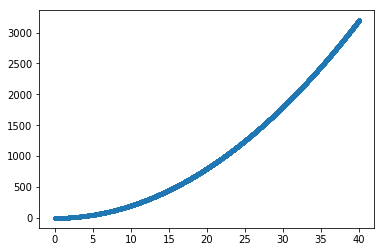

In [13]:
result = model.predict([x_final,z_final])
plt.plot(x_final, result[:,0],'.')
plt.show()

Here we plot the two sigmas. As we can see, the sigma for the first variable though for the second one the predicted sigma is quite wrong.

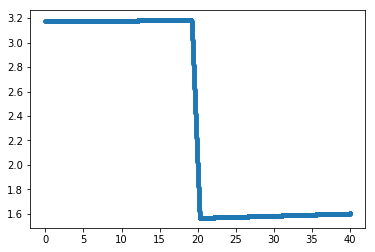

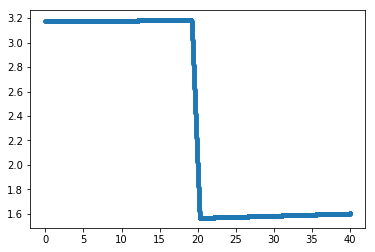

In [14]:
model_sigmas_x = Model(inputs=[input1], outputs=sigma1)
sigmas_x = model_sigmas_x.predict(x_final)
sigmas_x
plt.plot(x_final, np.abs(sigmas_x),'.')
plt.show()
model_sigmas_z = Model(inputs=[input2], outputs=sigma2)
sigmas_z = model_sigmas_z.predict(z_final)
sigmas_z
plt.plot(z_final, np.abs(sigmas_z),'.')
plt.show()